Using device: cpu
Successfully segmented the 'motorcycle'. The background is now transparent.
Segmented image saved to segmented_motorcycle.png


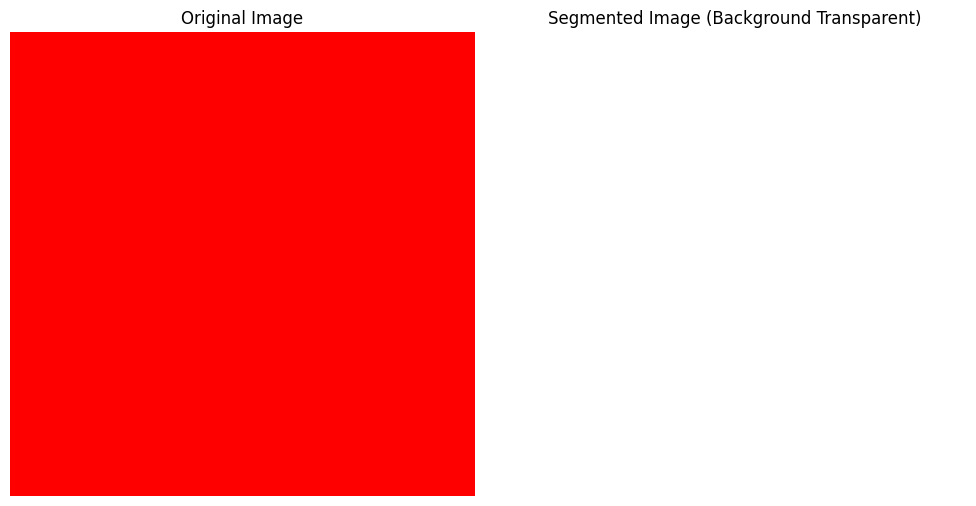

In [51]:
import torch
import torchvision.transforms as T
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True).to(device).eval()


COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def segment_image(image_path, target_class='motorcycle'):
    """
    Performs semantic segmentation on an image to isolate a target class
    (default: 'person') and removes the background.

    Args:
        image_path (str): Path to the input image.
        target_class (str): The name of the class to keep as foreground.

    Returns:
        PIL.Image.Image or None: A new image with the background made transparent
                                or None if an error occurs.
    """
    try:
        img = Image.open(image_path).convert("RGB")
        transform = T.Compose([T.ToTensor(),
                               T.Normalize(mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225])])
        input_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)['out'][0]
        output_predictions = output.argmax(0)


        target_class_index = COCO_INSTANCE_CATEGORY_NAMES.index(target_class)
        mask = (output_predictions == target_class_index).cpu().numpy()


        img_np = np.array(img).astype(np.uint8)
        alpha = np.zeros(mask.shape, dtype=np.uint8)
        alpha[mask] = 255
        alpha_resized = Image.fromarray(alpha).resize(img.size)
        img_np = np.dstack((img_np, np.array(alpha_resized)))

        return Image.fromarray(img_np)

    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
        return None
    except ValueError:
        print(f"Error: Target class '{target_class}' not found in the model's categories.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def display_segmented_image(original_image_path, segmented_image):
    original_img = Image.open(original_image_path).convert("RGB")

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(original_img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    if segmented_image:
        axes[1].imshow(segmented_image)
        axes[1].set_title("Segmented Image (Background Transparent)")
        axes[1].axis('off')
    else:
        axes[1].text(0.5, 0.5, "Segmentation Failed", ha='center', va='center')
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    input_image_path = "back.jpg"
    target = "motorcycle"


    segmented_output = segment_image(input_image_path, target_class=target)

    if segmented_output:
        print(f"Successfully segmented the '{target}'. The background is now transparent.")

        output_path = f"segmented_{target}.png"
        segmented_output.save(output_path)
        print(f"Segmented image saved to {output_path}")


        display_segmented_image(input_image_path, segmented_output)
    else:
        print("Semantic segmentation failed.")

In [ ]:
!pip install Pillow matplotlib